In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime

## DTEC series reading

In [2]:
with open("./data/PTEX_DTEC_series.dat", "+r") as DTECin:
    file_lines = DTECin.readlines()
    total_series = int(file_lines[0])

    time_series = []
    dtec_series = []
    for n in tqdm(range(2, 2*total_series + 1, 2)):
        time_n_data = np.array(tuple(map(lambda x: datetime.fromisoformat(x), [time_stamp.replace(" ", "").replace("\n", "") for time_stamp in file_lines[n-1].split(",")])))
        dtec_n_data = np.array(tuple(map(lambda x: float(x), file_lines[n].split(","))))

        time_series.append(time_n_data)
        dtec_series.append(dtec_n_data)

100%|██████████| 4912/4912 [00:06<00:00, 771.11it/s]


## Outliers index reading

In [3]:
SeriesLabels = np.loadtxt("./data/PTEX_Outliers.dat", dtype = int, delimiter = ",", usecols = (1,))
ArgOutliers = np.argwhere(SeriesLabels == -1).flatten()
ArgNotOutliers = np.argwhere(SeriesLabels != -1).flatten()

## Visualization of sample of outliers

In [4]:
SizeSample = 5

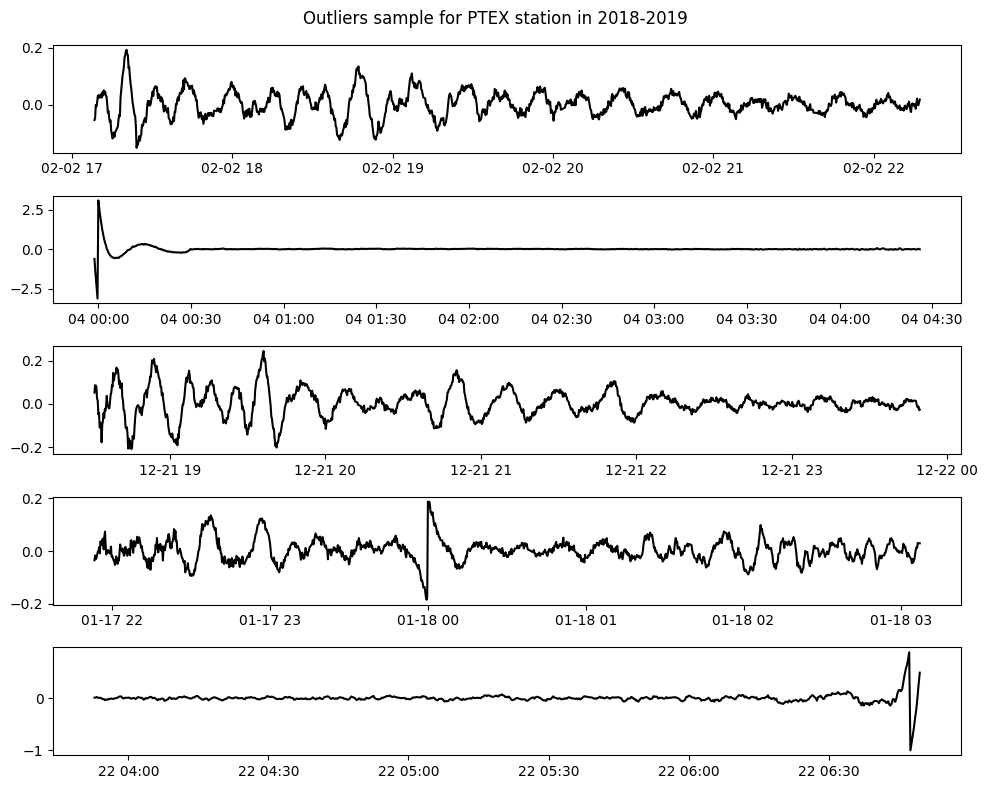

In [5]:
SampleIndexOutlers = np.random.choice(ArgOutliers, size = SizeSample, replace = False)

FigOutliers, SubplotsOut = plt.subplots(nrows = SizeSample, ncols = 1, figsize = (10, 8))
for n, index in enumerate(SampleIndexOutlers):
    SubplotsOut[n].plot(time_series[index], dtec_series[index], "-k", linewidth = 1.5)

FigOutliers.suptitle("Outliers sample for PTEX station in 2018-2019")
FigOutliers.tight_layout()

## Visualization of samples per cluster without outliers

In [6]:
UniqueLabels = np.unique(SeriesLabels[ArgNotOutliers]).astype(int)

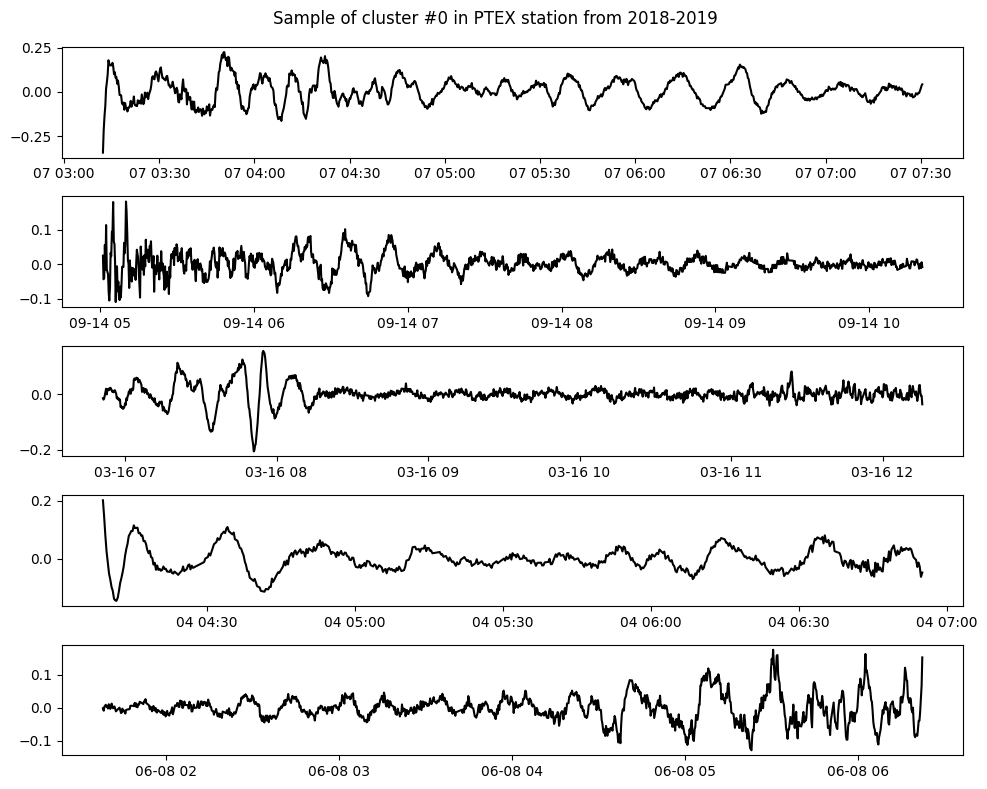

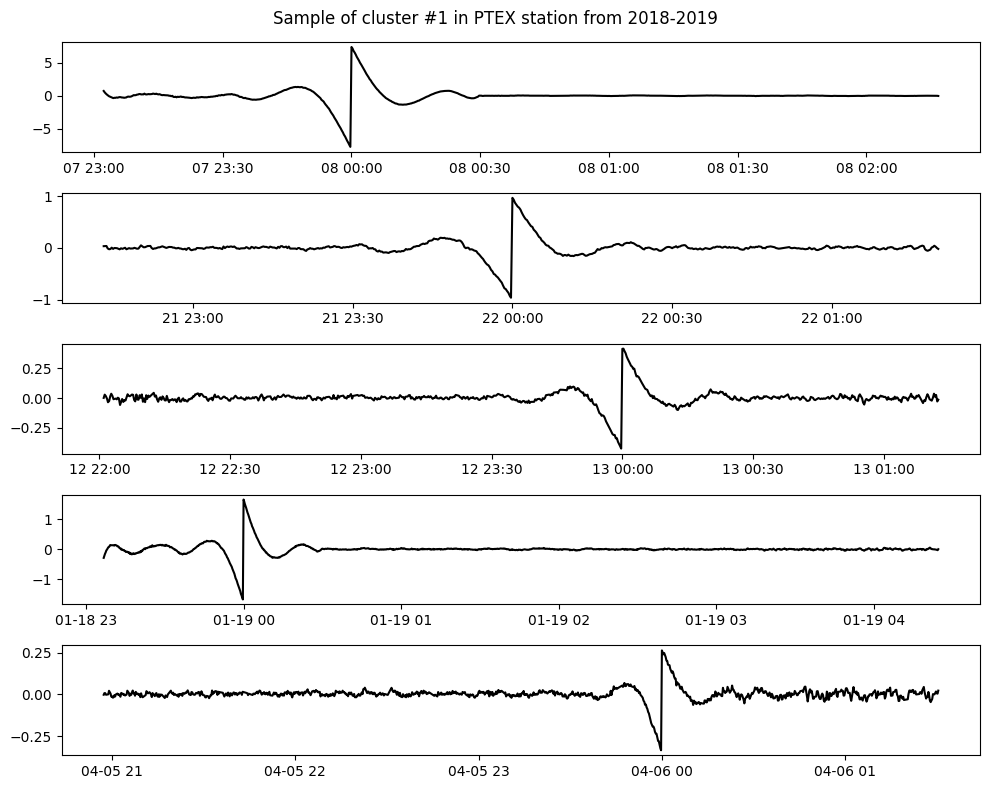

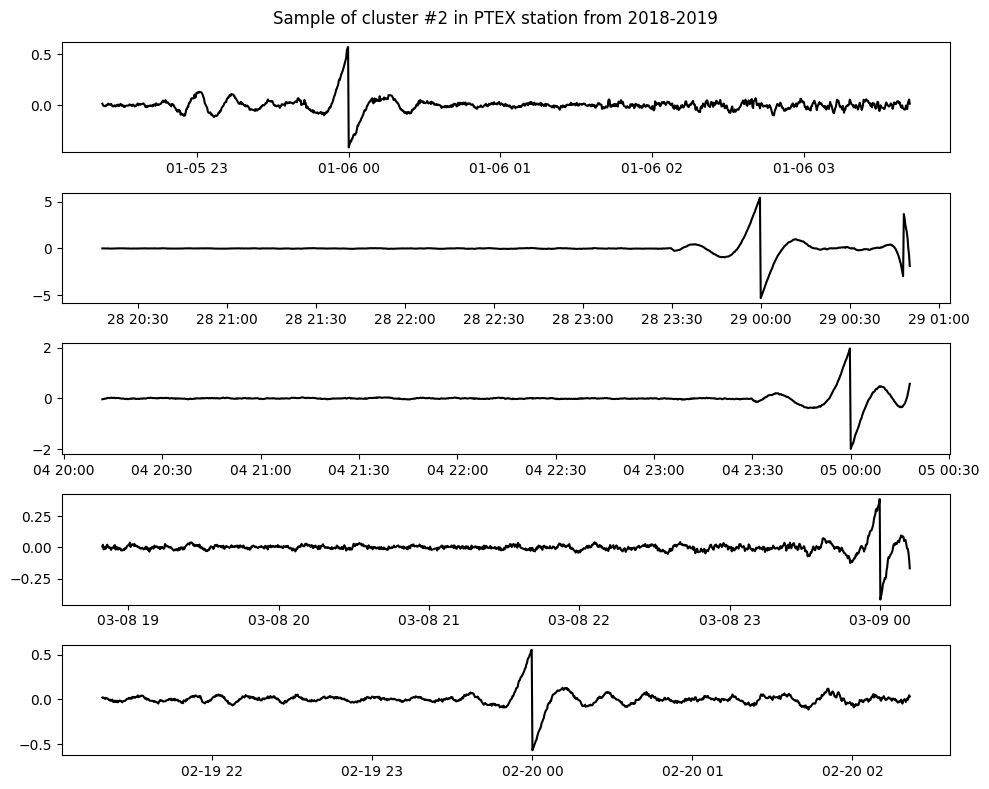

In [7]:
for label in UniqueLabels:
    SampleIndexByLabel = np.random.choice(np.argwhere(SeriesLabels == label).flatten(), size = SizeSample, replace = False)

    FigLabel, SubplotsLabel = plt.subplots(nrows = SizeSample, ncols = 1, figsize = (10, 8))
    for n, index in enumerate(SampleIndexByLabel):
        SubplotsLabel[n].plot(time_series[index], dtec_series[index], "-k", linewidth = 1.5)

    FigLabel.suptitle(f"Sample of cluster #{label} in PTEX station from 2018-2019")
    FigLabel.tight_layout()

In [8]:
from pywt import cwt
from sklearn.cluster import KMeans
from collections import Counter
import cv2

def compute_cwt(tec_series: np.ndarray, scales: np.ndarray, dt:float, wavelet:str) -> tuple[np.ndarray]:
    cwt_coeffs, freqs = cwt(data = tec_series, scales = scales,
                             wavelet = wavelet, sampling_period = dt,
                             method = "fft")
    power = np.abs(cwt_coeffs)**2.0
    periods = 1.0/(60.0*freqs)
    return cwt_coeffs, power, periods

def GetProminentContours(power_array:np.ndarray, labels_array:np.ndarray, time_seq:np.ndarray, period_seq:np.ndarray):
    gray_image = 255 * np.copy(labels_array).astype(np.uint8)

    contours = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

    reshaped_contours = [contour_array.reshape(contour_array.size//2, 2) for contour_array in contours if contour_array.size//2 > 4]
    del contours
    reshaped_contours_with_maxpower = [(power_array[contour_array[:,1], contour_array[:,0]].max(), contour_array) for contour_array in reshaped_contours]
    del reshaped_contours

    BigContour = max(reshaped_contours_with_maxpower, key = lambda contour: contour[0])[1]

    BigContourX = time_seq[BigContour[:,0]] 
    BigContourY = period_seq[BigContour[:,1]] 
    BigBoxX = (BigContourX.min(), BigContourX.max())
    BigBoxY = (BigContourY.min(), BigContourY.max())

    return (BigBoxX, BigBoxY)

def extract_prominent_series(index, time_seq, vtec_seq, wavelet, dj):
    dt = np.diff(time_seq).mean().total_seconds()
    if dt > 0.0:
        s0 = 2.0 * dt
        J = np.log2(time_seq.size * dt / s0)/dj
        scales = s0 * (2 ** (np.arange(J + 1) * dj))
            
        cwt_coeffs, cwt_power, periods = compute_cwt(vtec_seq, scales, dt, wavelet)
        mstids_periods_index = np.argwhere(periods <= 60.0)[:, 0]
        del cwt_coeffs
        cwt_power = cwt_power[mstids_periods_index, :]
            
        PowerPhase_KMeans = KMeans(n_clusters = 2, init = "k-means++")
        Labels = PowerPhase_KMeans.fit_predict(cwt_power.flatten().reshape(-1,1))
        numLabels = dict(Counter(Labels.tolist()))
        if numLabels[0] <= numLabels[1]:
            Labels[Labels == 0] = 2
            Labels[Labels == 1] = 0
            Labels[Labels == 2] = 1
        LabelsArray = Labels.reshape(cwt_power.shape)
        LabelBiggestContour = GetProminentContours(cwt_power, LabelsArray, time_seq, periods)
            
        BoxX = LabelBiggestContour[0]
        time_box_indexes = (BoxX[0] <= time_seq) & (time_seq <= BoxX[1])
        if time_box_indexes.any():
            time_box_values = time_seq[time_box_indexes]
            dtec_box_values = vtec_seq[time_box_indexes]
            
            return (index, time_box_values, dtec_box_values)
        else:
            return (index, np.array([]))

In [9]:
wavelet = "cmor1.5-1.5"
dj = 0.0625

prominent_dtec_series = []
prominent_time_series = []

for n in tqdm(range(len(dtec_series))):
    current_index, reduced_time, reduced_dtec = extract_prominent_series(n, time_series[n], dtec_series[n], wavelet, dj)

    prominent_dtec_series.append(reduced_dtec)
    prominent_time_series.append(reduced_time)

100%|██████████| 4912/4912 [26:51<00:00,  3.05it/s]


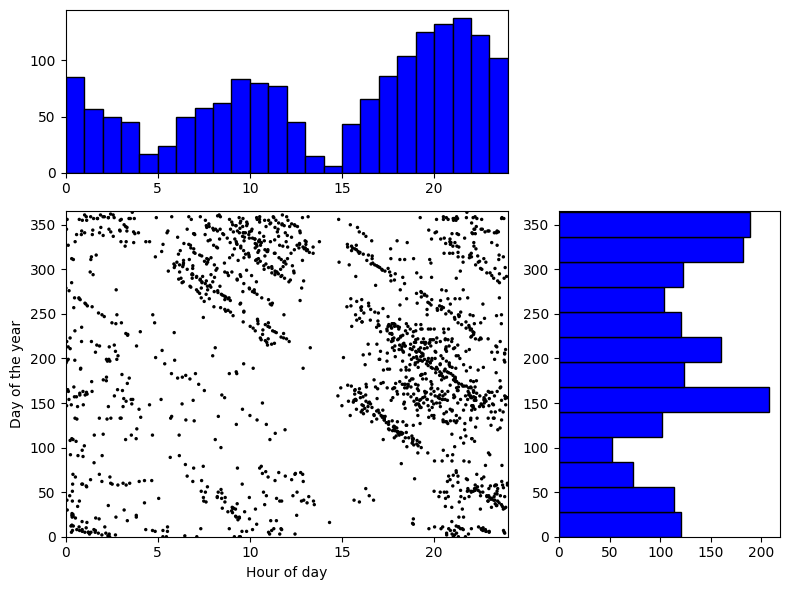

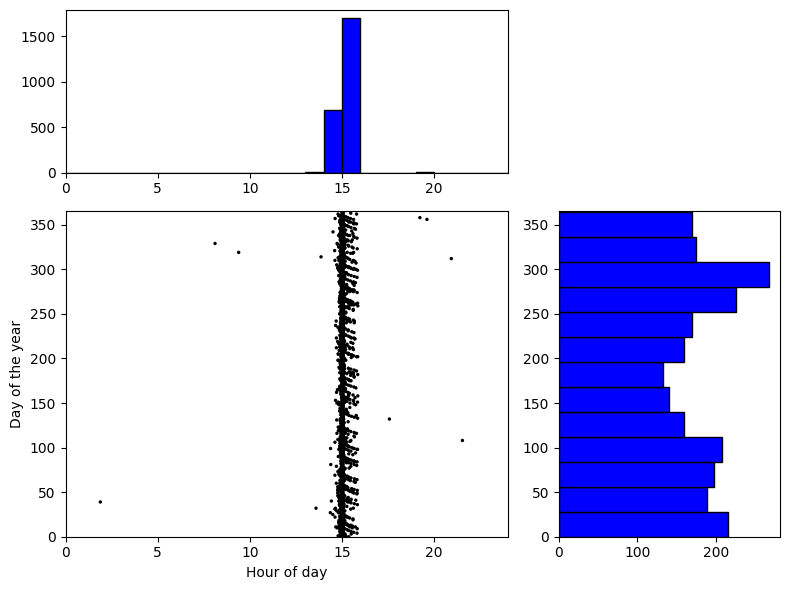

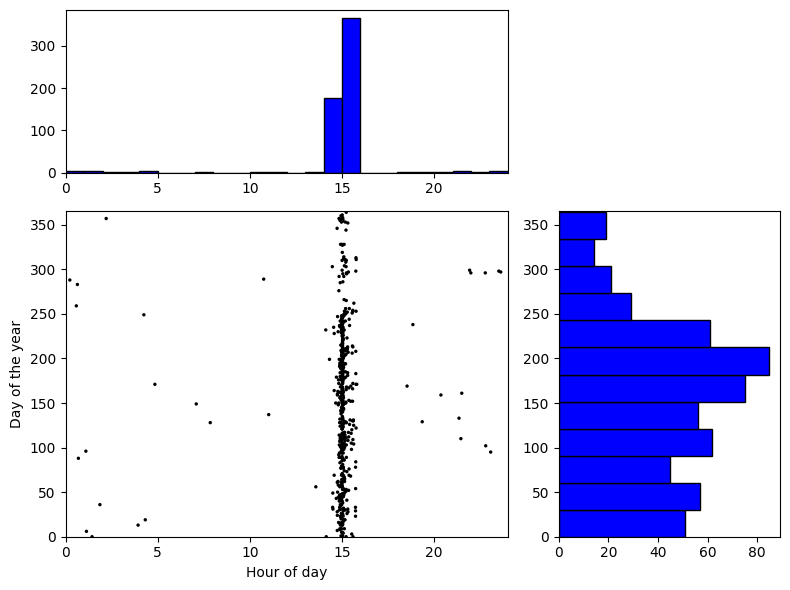

In [10]:
for label in UniqueLabels:
    SampleIndexByLabel = np.argwhere(SeriesLabels == label).flatten()
    HourPositions, DayMonthPositions = [], []
    for index in SampleIndexByLabel:
        current_prom_series = prominent_time_series[index]

        HourPosition = current_prom_series[0] + 0.5*(current_prom_series[0] - current_prom_series[-1])
        HourPosition = HourPosition.hour + HourPosition.minute/60.0 + HourPosition.second/3600.0

        DayMonthPosition = current_prom_series.astype('datetime64[D]')[current_prom_series.size//2]

        HourPositions.append(HourPosition)
        DayMonthPositions.append(DayMonthPosition)

    HourPositions = np.array(HourPositions, dtype = float)
    HourPositions = HourPositions - 8.0
    HourPositions = np.where(HourPositions < 0, HourPositions + 24.0, HourPositions)

    DayMonthPositions = np.array(DayMonthPositions, dtype = "datetime64[D]")
    TransDays = (DayMonthPositions - DayMonthPositions.min()).astype("timedelta64[D]").astype(int)
    TransDays = TransDays % 365

    Figure, Subplot = plt.subplot_mosaic([["HourHist", "."],
                                          ["Scatter", "DayMonthHist"]],
                                          height_ratios = (1,2),
                                          width_ratios = (2,1),
                                          figsize = (8, 6))

    BinsHours = Subplot["HourHist"].hist(HourPositions, fc = "blue", ec = "black", bins = tuple(range(0, 25)))[1]
    BinsDayMonth = Subplot["DayMonthHist"].hist(TransDays, fc = "blue", ec = "black", bins = "fd", orientation = "horizontal")[1]
    Subplot["Scatter"].scatter(HourPositions, TransDays, fc = "black", ec = "None", s = 6)

    Subplot["Scatter"].set_xlim(0, 24)
    Subplot["Scatter"].set_ylim(0, 365)
    Subplot["HourHist"].set_xlim(0, 24)
    Subplot["DayMonthHist"].set_ylim(0, 365)

    Subplot["Scatter"].set_xlabel("Hour of day")
    Subplot["Scatter"].set_ylabel("Day of the year")

    Figure.tight_layout()